In [1]:
import pandas as pd
import random
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Get S&P 500 tickers
def get_sp500_tickers(sample_size=250):
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url)[0]    
    tickers = table['Symbol'].tolist()
    sample_tickers = random.sample(tickers, sample_size)
    return sample_tickers

In [3]:
# Fetch historical data
def get_historical_data(tickers):
    data = pd.DataFrame()
    for i in tickers:
        stock_data = yf.download(i, start="2022-01-01", end="2024-09-10")
        data[i] = stock_data['Adj Close']
    return data

In [4]:
# Perform the ADF test for stationarity
def adf_test(series):
    result = adfuller(series)
    return result[1]  # Return p-value

In [5]:
# Calculate z-score for the residuals
def calculate_zscore(residuals):
    mean = residuals.rolling(window=30).mean()
    std = residuals.rolling(window=30).std()
    zscore = (residuals - mean) / std
    return zscore

In [6]:
# Cointegration test between pairs of stocks 
def cointegration_test(data):
    pairs = []
    results = []
    residuals_dict = {}

    tickers = data.columns
    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            x = data[tickers[i]].dropna()
            y = data[tickers[j]].dropna()

            x, y = x.align(y, join='inner')  # Align x and y by matching labels (dates)
            if x.empty or y.empty:
                continue

            try:
                score, p_value, _ = coint(x, y)
            except ValueError:
                continue

            ratio = x / y
            adf_p_value = adf_test(ratio)

            # Store the residuals from the OLS regression for feature generation
            ols_result = OLS(x, y).fit()
            residuals = ols_result.resid

            pairs.append((tickers[i], tickers[j]))
            results.append((tickers[i], tickers[j], score, p_value, adf_p_value))
            residuals_dict[(tickers[i], tickers[j])] = residuals

    results_df = pd.DataFrame(results, columns=['Stock 1', 'Stock 2', 'Cointegration Score', 'Cointegration p-value', 'ADF p-value'])
    return results_df, residuals_dict

In [7]:
# Function to calculate the average time for z-score to return to 0 after being >1 or <-1
def calculate_avg_reversion_time(zscore):
    threshold_crossings = np.where((zscore > 1) | (zscore < -1))[0]
    reversion_times = []
    
    for crossing in threshold_crossings:
        subsequent_zero_crossings = np.where(np.abs(zscore[crossing:]) < 0.5)[0]  # Closer to 0
        if len(subsequent_zero_crossings) > 0:
            reversion_times.append(subsequent_zero_crossings[0])
    
    if reversion_times:
        return int(np.mean(reversion_times))  # Return average time in days
    else:
        return 21  # Default to 21 days if no crossings

In [8]:
# Generate features and target for ML model
def generate_features_and_target(residuals, zscore):
    residuals = residuals.dropna()
    zscore = zscore.dropna()

    avg_reversion_time = calculate_avg_reversion_time(zscore)
    
    # Define target: 1 if residuals increase, -1 if decrease after avg_reversion_time
    target = np.where(residuals.shift(-avg_reversion_time) > residuals, 1, -1)

    # Align the target to match the residuals' indices
    target = pd.Series(target, index=residuals.index)
    
    # The feature is the z-score of the residuals
    features = zscore
    
    return features, target, avg_reversion_time

In [9]:
# Get S&P 500 tickers and historical data
ticks = get_sp500_tickers()
historical_data = get_historical_data(ticks)

# Cointegration test
results_df, residuals_dict = cointegration_test(historical_data)

# Filter pairs with the lowest ADF p-values
filtered_results = results_df[results_df['ADF p-value'] < 0.05]

# Sort pairs by cointegration score to find the most cointegrated pair
sorted_results = filtered_results.sort_values(by='Cointegration Score', ascending=True)

SyntaxError: incomplete input (40730542.py, line 12)

In [151]:
# Get the top cointegrated pair
top_pair = sorted_results.iloc[0]
stock1, stock2 = top_pair['Stock 1'], top_pair['Stock 2']

# Generate residuals
residuals = residuals_dict[(stock1, stock2)]

# Calculate z-score of the residuals
zscore = calculate_zscore(residuals)

# Generate features and target
features, target, avg_reversion_time = generate_features_and_target(residuals, zscore)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.values.reshape(-1, 1), target, test_size=0.2, random_state=42, shuffle=False)

# Train the model
model = RandomForestClassifier()
#model = SVC(kernel='rbf', C=1.0)
#model = LogisticRegression()
#model = KNeighborsClassifier(n_neighbors=5)
#model = GradientBoostingClassifier()
#model = AdaBoostClassifier()
#model = GaussianNB()
#model = DecisionTreeClassifier()
#model = MLPClassifier(hidden_layer_sizes=(100, 50))

model.fit(X_train, y_train)

# Predict signals on the test set
y_pred = model.predict(X_test)

print("historica_data:", historical_data.head())
print("results_df:", results_df.head())
print("filtered_results:", filtered_results.head())
print("sorted_results:", sorted_results)

historica_data:                    ADP         AWK           V          HD        OKE  \
Date                                                                    
2023-01-03  228.564484  148.568024  204.583511  301.588745  58.094604   
2023-01-04  229.641617  151.527802  209.732849  305.235596  58.548904   
2023-01-05  224.688690  149.117554  208.253143  301.168671  58.903248   
2023-01-06  230.968811  152.578674  214.803284  303.135284  60.484177   
2023-01-09  230.343658  152.752213  215.641785  303.402618  61.501789   

                  ENPH        AES         ZBH        CMG        KHC  ...  \
Date                                                                 ...   
2023-01-03  253.309998  26.421135  125.783310  27.422600  37.691875  ...   
2023-01-04  251.639999  25.641003  126.949440  27.521000  38.117046  ...   
2023-01-05  240.369995  24.315716  124.597427  27.283199  38.200230  ...   
2023-01-06  233.649994  24.842070  124.221886  28.041201  39.364811  ...   
2023-01-09  227.

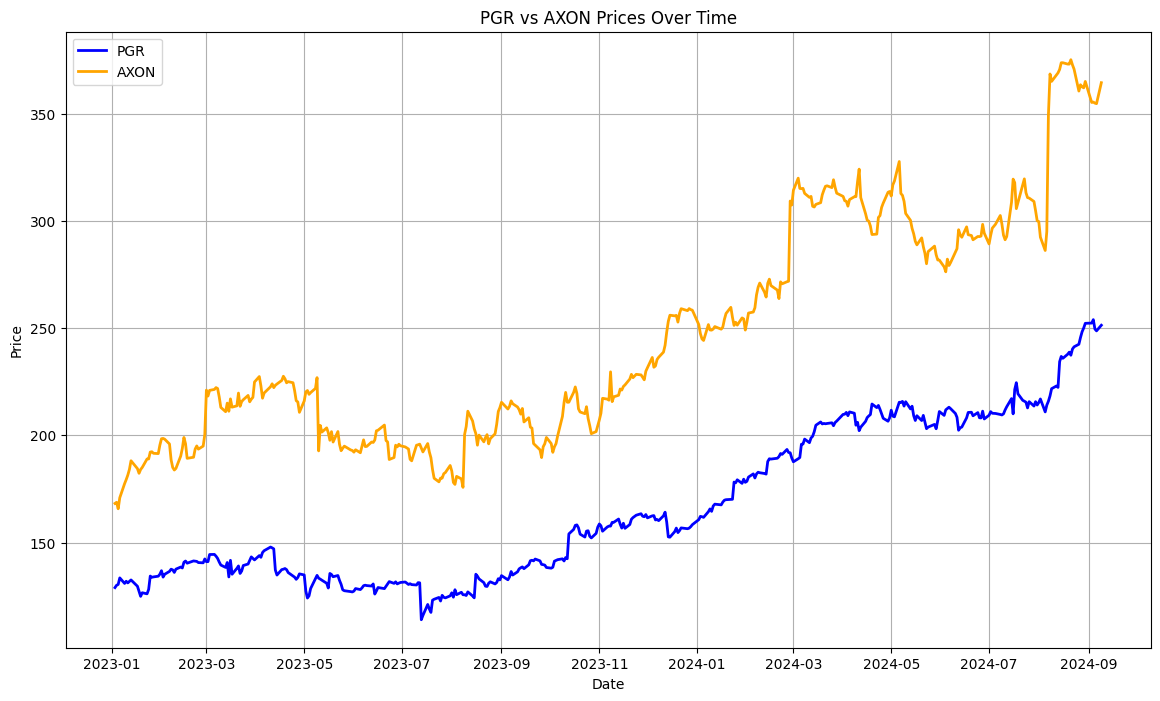

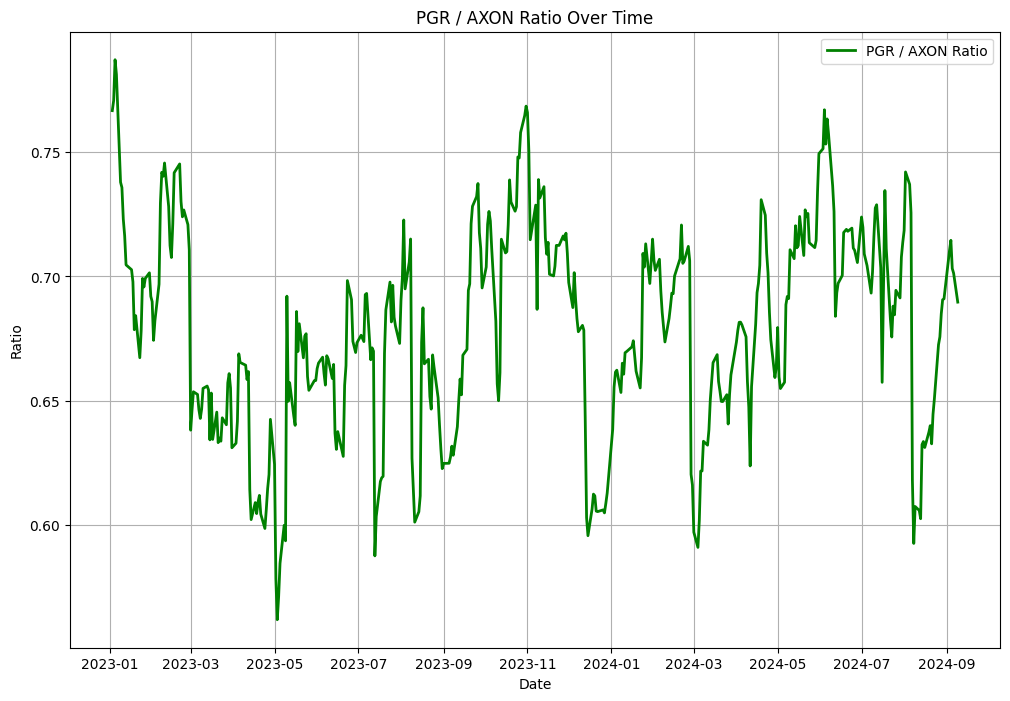

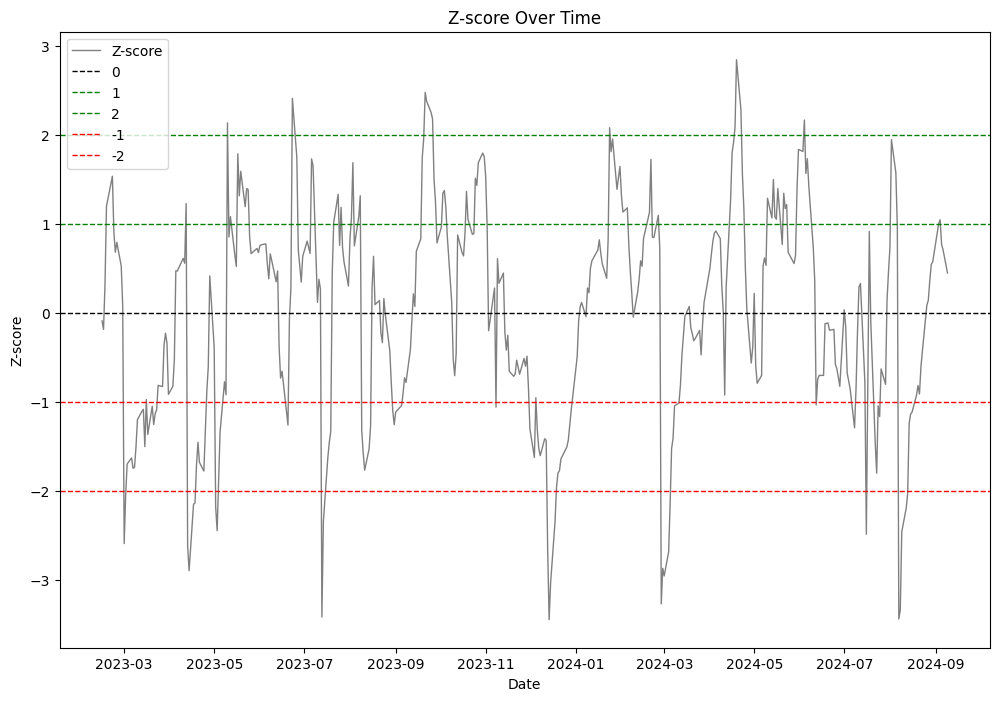

In [145]:
# Plot Stock 1 and Stock 2 Prices
def plot_stocks(stock1, stock2, historical_data):
    plt.figure(figsize=(14, 8))
    
    # Plot stock1 price
    plt.plot(historical_data[stock1], label=stock1, color='blue', linewidth=2)
    
    # Plot stock2 price
    plt.plot(historical_data[stock2], label=stock2, color='orange', linewidth=2)
    
    # Labels and title
    plt.title(f'{stock1} vs {stock2} Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Residuals
def plot_residuals(residuals):
    plt.figure(figsize=(12, 8))
    
    # Plot the residuals of Stock 1 to Stock 2
    plt.plot(residuals, label='Residuals', color='green', linewidth=2)
    
    # Labels and title
    plt.title('Residuals')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot residuals zscore
def plot_zscore(zscore):
    plt.figure(figsize=(12, 8))
    plt.plot(zscore, label='Residuals Z-Score', color='gray', linewidth=1)
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='0')
    plt.axhline(y=1, color='green', linestyle='--', linewidth=1, label='1')
    plt.axhline(y=2, color='green', linestyle='--', linewidth=1, label='2')
    plt.axhline(y=-1, color='red', linestyle='--', linewidth=1, label='-1')
    plt.axhline(y=-2, color='red', linestyle='--', linewidth=1, label='-2')

    # Labels and title
    plt.title('Residuals Z-Score Over Time')
    plt.xlabel('Date')
    plt.ylabel('Residual Z-Score')
    plt.legend()
    plt.show()

# Call the functions to plot
plot_stocks(stock1, stock2, historical_data)
plot_residuals(residuals)
plot_zscore(zscore)

In [152]:
# Define test period stock prices for the top cointegrated pair
stock1_prices_test = historical_data[stock1][-len(y_test):]
stock2_prices_test = historical_data[stock2][-len(y_test):]

# Backtest using ML signals
def backtest_ml_strategy(stock1_prices, stock2_prices, ml_predictions, avg_time):
    positions = []
    returns = []

    position = None
    entry_stock1_price = None
    entry_stock2_price = None

    for i in range(len(ml_predictions) - avg_time):  # Ensure enough days to look ahead
        if ml_predictions[i] == 1 and position is None:
            # Enter long (Long Stock 1, Short Stock 2)
            entry_stock1_price = stock1_prices.iloc[i]
            entry_stock2_price = stock2_prices.iloc[i]
            exit_stock1_price = stock1_prices.iloc[i + avg_time]
            exit_stock2_price = stock2_prices.iloc[i + avg_time]
            position = 'long'
            positions.append(('long', i))

            # Calculate return for a long position
            long_return = (exit_stock1_price - entry_stock1_price) / entry_stock1_price
            short_return = (entry_stock2_price - exit_stock2_price) / entry_stock2_price
            returns.append(long_return + short_return)
            positions.append(('exit', i + avg_time))
            position = None  # Exit immediately

        elif ml_predictions[i] == -1 and position is None:
            # Enter short (Short Stock 1, Long Stock 2)
            entry_stock1_price = stock1_prices.iloc[i]
            entry_stock2_price = stock2_prices.iloc[i]
            exit_stock1_price = stock1_prices.iloc[i + avg_time]
            exit_stock2_price = stock2_prices.iloc[i + avg_time]
            position = 'short'
            positions.append(('short', i))

            # Calculate return for a short position
            short_return = (entry_stock1_price - exit_stock1_price) / entry_stock1_price
            long_return = (exit_stock2_price - exit_stock2_price) / entry_stock2_price
            returns.append(short_return + long_return)
            positions.append(('exit', i + avg_time))
            position = None  # Exit immediately

    return positions, returns

# Backtest strategy
positions, returns = backtest_ml_strategy(stock1_prices_test, stock2_prices_test, y_pred, avg_reversion_time)

# Convert returns to pandas Series
returns = pd.Series(returns)

# Calculating risk-free rate
risk_free_rate = 0.02  # Assuming a 2% annual risk-free rate
daily_risk_free_rate = (1 + risk_free_rate) ** (1 / 252) - 1  # Adjusted for daily returns

# Excess returns (returns - daily risk-free rate)
excess_returns = returns - daily_risk_free_rate

# Mean of excess returns
mean_excess_return = excess_returns.mean()

# Standard deviation of returns (volatility)
volatility = returns.std()

sharpe_ratio = mean_excess_return / volatility

# Print positions and returns
print("Positions:", positions)
print("Returns:", returns)
print("Total return:", sum(returns))
print(f"Sharpe Ratio: {sharpe_ratio}")

Positions: [('short', 3), ('exit', 45), ('short', 4), ('exit', 46), ('long', 13), ('exit', 55), ('long', 16), ('exit', 58), ('long', 18), ('exit', 60), ('long', 19), ('exit', 61), ('long', 20), ('exit', 62), ('long', 22), ('exit', 64), ('long', 23), ('exit', 65), ('long', 24), ('exit', 66), ('long', 26), ('exit', 68)]
Returns: 0     0.078113
1     0.054536
2    -0.038367
3    -0.223956
4    -0.148423
5    -0.111148
6    -0.116673
7    -0.142230
8    -0.139742
9    -0.153331
10   -0.107942
dtype: float64
Total return: -1.0491616594782331
Sharpe Ratio: -1.0443126072885076


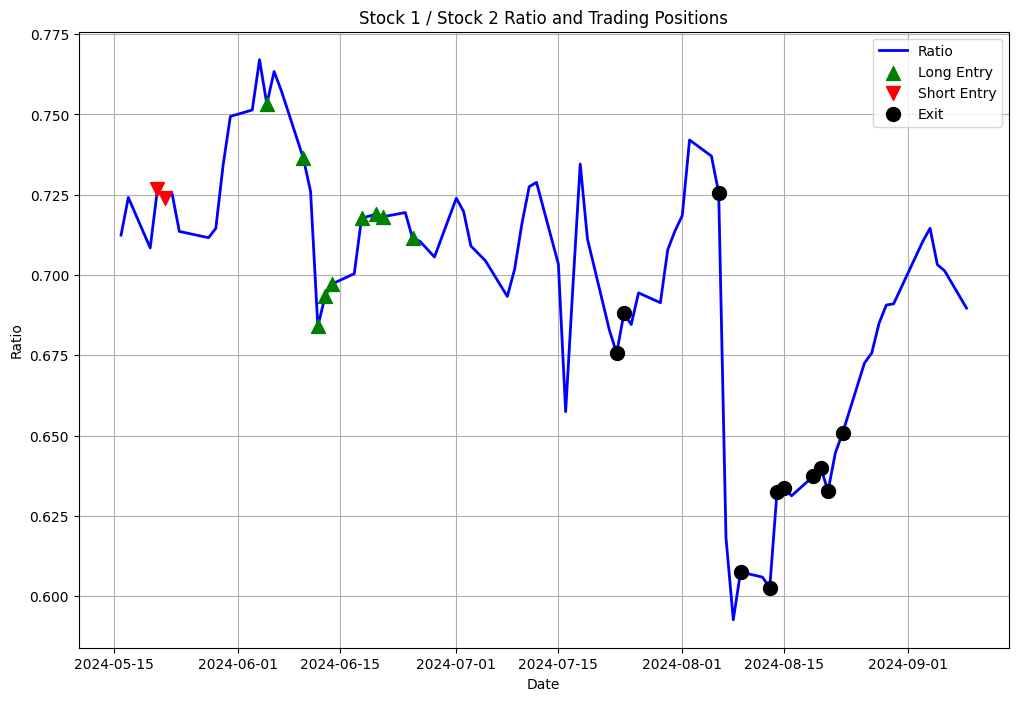

In [153]:
# Plot residuals with positions
def plot_residuals_with_positions(residuals, positions):
    plt.figure(figsize=(12, 8))
    plt.plot(residuals.index, residuals, label="Residuals", color='gray', linewidth=1)

    # Plot long, short, and exit positions
    long_positions = [i for pos, i in positions if pos == 'long']
    short_positions = [i for pos, i in positions if pos == 'short']
    exit_positions = [i for pos, i in positions if pos == 'exit']

    plt.scatter(residuals.index[long_positions], residuals.iloc[long_positions], color='green', marker='^', label='Long Entry', s=100, zorder=5)
    plt.scatter(residuals.index[short_positions], residuals.iloc[short_positions], color='red', marker='v', label='Short Entry', s=100, zorder=5)
    plt.scatter(residuals.index[exit_positions], residuals.iloc[exit_positions], color='black', marker='o', label='Exit', s=100, zorder=5)

    plt.axhline(0, color='black', linestyle='--')
    plt.title("Cointegration Residuals with Positions")
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plot function with the ratio and positions from the backtest
plot_residuals_with_positions(ratio[-len(y_test):], positions)